In [1]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from scipy import math

# modeling tools
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


# classifiers
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.cross_decomposition import PLSRegression

# predict RBGs 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans

# feature selection
from sklearn.feature_selection import RFE
import eli5

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# plotting
import altair as alt
import colorsys
from PIL import Image 
import matplotlib.pyplot as plt

/home/ilana/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ilana/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


## Exploratory Data Analysis & Data Wrangling
Taking a look at what kind of data we're working with, distribution of values, etc

In [2]:
glaze_df = pd.read_csv("./data/glazy_data_june_2019.csv")

In [3]:
glaze_df.shape

(7947, 330)

In [4]:
# get rid of all rows where NaN in rbg columns
glaze_df = glaze_df.iloc[glaze_df[['rgb_r', 'rgb_g', 'rgb_b']].dropna(axis = 0).index]

In [5]:
# if column is an oxide, replace NaNs with 0
for column in glaze_df.columns:
    if "O" in column:
        glaze_df[[column]] = glaze_df[column].fillna(0)

glaze_df.head()

,id,name,created_by_user_id,material_type_id,material_type,material_state_id,material_state,rgb_r,rgb_g,rgb_b,...,Tm2O3_percent_mol,Yb2O3_percent_mol,Lu2O3_percent_mol,SiO2_Al2O3_ratio_umf,R2O_umf,RO_umf,SiO2_Al2O3_ratio_xumf,R2O_xumf,RO_xumf,loi
0,1,Base Glaze Peltzman,1,460,Glaze,2.0,Production,255.0,255.0,255.0,...,0.0,0.0,0.0,9.3380,0.2199,0.7801,9.3380,0.2196,0.7804,8.7865
1,3,Clay Porcelain Peltzman,1,260,Porcelain,2.0,Production,255.0,255.0,255.0,...,0.0,0.0,0.0,4.4236,0.7949,0.2051,4.4236,0.7542,0.2458,6.3251
3,5,Pier's Pure Lux-Deluxe Revised,1,470,Clear,2.0,Production,255.0,255.0,255.0,...,0.0,0.0,0.0,9.7715,0.2249,0.7751,9.7715,0.2249,0.7751,4.6680
4,6,Blue Acero,1,750,Blue,2.0,Production,13.0,153.0,186.0,...,0.0,0.0,0.0,4.6546,0.2457,0.7543,4.6546,0.2359,0.7641,13.0899
5,8,#207.3,1,470,Clear,2.0,Production,255.0,255.0,255.0,...,0.0,0.0,0.0,9.0791,0.2036,0.7964,9.0791,0.2030,0.7970,13.1826


In [6]:
# there are several columns with only 0 values...
describe_df = glaze_df.describe()
describe_df

,id,created_by_user_id,material_type_id,material_state_id,rgb_r,rgb_g,rgb_b,is_analysis,is_primitive,is_theoretical,...,Tm2O3_percent_mol,Yb2O3_percent_mol,Lu2O3_percent_mol,SiO2_Al2O3_ratio_umf,R2O_umf,RO_umf,SiO2_Al2O3_ratio_xumf,R2O_xumf,RO_xumf,loi
count,5447.000000,5447.000000,5447.000000,5444.000000,5447.000000,5447.000000,5447.000000,5447.0,5447.0,5447.0,...,5447.0,5447.0,5447.0,5447.000000,5447.000000,5447.000000,5447.000000,5447.000000,5447.000000,5447.000000
mean,5374.159721,633.510006,647.411786,2.060250,174.674867,169.390490,163.965486,0.0,0.0,0.0,...,0.0,0.0,0.0,8.722661,0.331040,0.666757,8.723394,0.327094,0.671621,9.564456
std,5665.554521,1051.420057,219.127932,0.480033,101.602293,104.179402,106.187538,0.0,0.0,0.0,...,0.0,0.0,0.0,12.238713,0.213631,0.215356,12.238250,0.204002,0.205084,5.467321
min,1.000000,1.000000,110.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.386300
25%,2006.000000,1.000000,470.000000,2.000000,79.000000,54.000000,41.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,5.423700,0.196850,0.600700,5.423700,0.197150,0.608700,6.322950
50%,4078.000000,1.000000,580.000000,2.000000,252.000000,241.000000,232.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,7.611700,0.264700,0.734500,7.611700,0.269900,0.729500,9.172700
75%,6723.500000,1016.000000,760.000000,2.000000,255.000000,255.000000,255.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,9.704300,0.397150,0.802650,9.704300,0.390300,0.802450,11.943150
max,39066.000000,8950.000000,1180.000000,3.000000,255.000000,255.000000,255.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,423.443500,1.000000,1.000000,423.443500,1.000000,1.000000,50.383000


In [7]:
# identify zero columns to drop
zero_columns = []
columns = describe_df.columns
for column in columns:
    if glaze_df[column].min() == 0 and glaze_df[column].max() == 0:
        zero_columns.append(column)

In [8]:
glaze_df = glaze_df.drop(columns = zero_columns)
glaze_df = glaze_df.reset_index(drop = True)

In [9]:
print(glaze_df["transparency_type"].value_counts())
glaze_df["surface_type"].value_counts()

Opaque         1445
Transparent     532
Translucent     519
Semi-opaque     506
Name: transparency_type, dtype: int64


Glossy            1921
Matte              584
Glossy - Semi      466
Satin - Matte      390
Satin              310
Matte - Semi       246
Matte - Smooth      53
Matte - Dry         36
Matte - Stony       22
Name: surface_type, dtype: int64

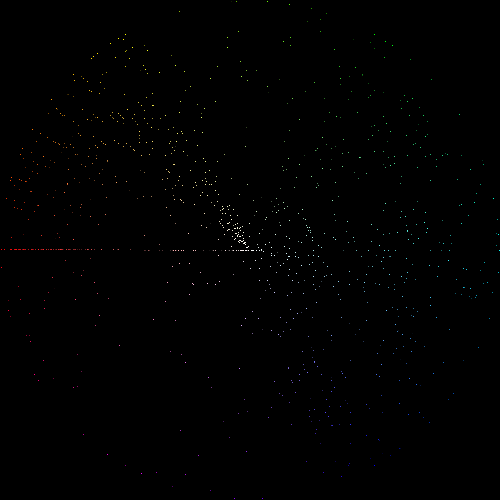

In [17]:
# visualize color distribution in dataset

# reference: https://stackoverflow.com/questions/51585989/how-do-you-map-rgb-color-values-onto-a-color-wheel
rgbs = list(zip(glaze_df.rgb_r.astype(int), glaze_df.rgb_g.astype(int), glaze_df.rgb_b.astype(int)))

# creating a image object 
img = Image.new('RGB', (500,500), (0, 0, 0))
img.save(r'./img/rgb_viz.png', "PNG")
  
width, height = img.size 
highest_value = np.zeros((width, height))


def rgb_to_point(rgb):
    hsv = colorsys.rgb_to_hsv(*rgb)
    rads = math.tau * hsv[0] - math.pi
    mag = hsv[1] * (width/2) - 1 
    x = int(math.cos(rads) * mag + (width/2)) 
    y = int(math.sin(rads) * mag + (height/2))
    if(hsv[2] > highest_value[x][y]):
        highest_value[x][y] = hsv[2]
        return (x, y)

for pixel in rgbs: # iterate over rgb vals in df
    c = rgb_to_point(pixel)
    if(c):
        img.putpixel(c, pixel)

display(img)

In [10]:
# dropna for transparency column
glaze_df = glaze_df.iloc[glaze_df[["transparency_type"]].dropna(axis = 0).index]

In [11]:
# columns 14 onwards are related to chemical comp - BUT repeats with ratios and percent mol
glaze_df.iloc[:3, 14:]


,SiO2_percent,Al2O3_percent,B2O3_percent,Li2O_percent,K2O_percent,Na2O_percent,KNaO_percent,MgO_percent,CaO_percent,SrO_percent,...,SnO2_percent_mol,Pr2O3_percent_mol,Er2O3_percent_mol,SiO2_Al2O3_ratio_umf,R2O_umf,RO_umf,SiO2_Al2O3_ratio_xumf,R2O_xumf,RO_xumf,loi
0,59.3609,10.7873,0.0000,0.0000,1.9939,3.1374,5.1314,0.0052,10.8304,0.0,...,0.0,0.0,0.0,9.3380,0.2199,0.7801,9.3380,0.2196,0.7804,8.7865
2,53.4984,9.2907,2.0827,1.0129,0.2954,1.1114,1.4068,0.0358,0.1243,0.0,...,0.0,0.0,0.0,9.7715,0.2249,0.7751,9.7715,0.2249,0.7751,4.6680
3,47.5690,17.3426,0.0000,0.0000,5.0019,1.5421,6.5440,1.2274,11.7201,0.0,...,0.0,0.0,0.0,4.6546,0.2457,0.7543,4.6546,0.2359,0.7641,13.0899


In [12]:
# only want columns with percent 
regex = r'percent$'
percent_oxide_cols = []
for column in glaze_df.columns: 
    if re.search(regex, column):
        percent_oxide_cols.append(column)

percent_oxide_cols

['SiO2_percent',
 'Al2O3_percent',
 'B2O3_percent',
 'Li2O_percent',
 'K2O_percent',
 'Na2O_percent',
 'KNaO_percent',
 'MgO_percent',
 'CaO_percent',
 'SrO_percent',
 'BaO_percent',
 'ZnO_percent',
 'PbO_percent',
 'P2O5_percent',
 'F_percent',
 'V2O5_percent',
 'Cr2O3_percent',
 'MnO_percent',
 'MnO2_percent',
 'FeO_percent',
 'Fe2O3_percent',
 'CoO_percent',
 'NiO_percent',
 'CuO_percent',
 'Cu2O_percent',
 'TiO2_percent',
 'ZrO2_percent',
 'SnO2_percent',
 'Pr2O3_percent',
 'Er2O3_percent']

               percent makeup
SiO2_percent        50.747529
Al2O3_percent       11.847720
B2O3_percent         3.162412
Li2O_percent         0.444048
K2O_percent          2.724555
Na2O_percent         3.072274
KNaO_percent         5.796829
MgO_percent          1.655674
CaO_percent          8.194673
SrO_percent          0.679333
BaO_percent          0.747619
ZnO_percent          1.241848
PbO_percent          0.135504
P2O5_percent         0.350281
F_percent            0.119915
V2O5_percent         0.003515
Cr2O3_percent        0.058951
MnO_percent          0.037065
MnO2_percent         0.427228
FeO_percent          0.020802
Fe2O3_percent        1.807926
CoO_percent          0.191136
NiO_percent          0.021163
CuO_percent          0.410088
Cu2O_percent         0.002967
TiO2_percent         1.046973
ZrO2_percent         0.525669
SnO2_percent         0.551703
Pr2O3_percent        0.004345
Er2O3_percent        0.002179


/home/ilana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Avegage Chemical Makeup')

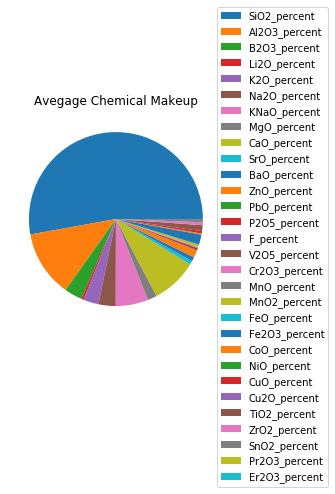

In [13]:
avg_glaze_chem = pd.DataFrame(np.mean(glaze_df[percent_oxide_cols]), columns=['percent makeup'])
print(avg_glaze_chem)                       
fig1, ax1 = plt.subplots()
ax1.pie(avg_glaze_chem)
ax1.legend(labels = percent_oxide_cols, loc = 'best',  bbox_to_anchor=(0.5, 0., 1, 1.5))
ax1.set_title("Avegage Chemical Makeup")

In [14]:
#only want to start working with this subset of columns
filter_cols = ['id', 'rgb_r', 'rgb_g', 'rgb_b', 'surface_type', 'transparency_type', 'from_orton_cone']
filter_cols.extend(percent_oxide_cols)
glaze_df_filtered = glaze_df[filter_cols]
glaze_df_filtered.head()

,id,rgb_r,rgb_g,rgb_b,surface_type,transparency_type,from_orton_cone,SiO2_percent,Al2O3_percent,B2O3_percent,...,Fe2O3_percent,CoO_percent,NiO_percent,CuO_percent,Cu2O_percent,TiO2_percent,ZrO2_percent,SnO2_percent,Pr2O3_percent,Er2O3_percent
0,1,255.0,255.0,255.0,Glossy,Transparent,8,59.3609,10.7873,0.0000,...,0.0664,0.0000,0.0,0.0000,0.0,0.0190,0.0000,0.0,0.0,0.0
2,5,255.0,255.0,255.0,Glossy,Transparent,8,53.4984,9.2907,2.0827,...,0.0837,0.0000,0.0,0.0128,0.0,0.0035,0.9372,0.0,0.0,0.0
3,6,13.0,153.0,186.0,Satin - Matte,Semi-opaque,9,47.5690,17.3426,0.0000,...,1.8451,0.1214,0.0,0.0000,0.0,0.0880,0.0000,0.0,0.0,0.0
6,11,255.0,255.0,255.0,Glossy,Transparent,9,67.4734,13.3678,0.0000,...,0.0388,0.0000,0.0,0.0000,0.0,0.0194,0.0000,0.0,0.0,0.0
7,12,255.0,255.0,255.0,Glossy,Transparent,10,64.8399,11.8275,0.0000,...,0.0968,0.0000,0.0,0.0000,0.0,0.0753,0.0000,0.0,0.0,0.0


In [15]:
# found weird values in this column! - Convert cone values to temperature integers?
glaze_df_filtered["from_orton_cone"].value_counts() #5 &#189 - means 1/2 hml; 

6            924
5            474
10           443
9            380
04           252
4             95
8             89
5 &#189;      65
05 &#189;     45
03            39
1             28
06            27
7             26
05            21
08            13
02            12
2              7
07             6
11             5
3              4
015            2
014            2
012            1
13             1
010            1
022            1
01             1
Name: from_orton_cone, dtype: int64

In [16]:
# use chemicals and RBGs to train SKIP FIRING TEMP FOR NOW
idx = list(range(1,4)) + list(range(7, len(glaze_df_filtered.columns)))
X = glaze_df_filtered.iloc[:, idx]
y = glaze_df["transparency_type"]
print(X.columns)
print(X.shape, y.shape)

Index(['rgb_r', 'rgb_g', 'rgb_b', 'SiO2_percent', 'Al2O3_percent',
       'B2O3_percent', 'Li2O_percent', 'K2O_percent', 'Na2O_percent',
       'KNaO_percent', 'MgO_percent', 'CaO_percent', 'SrO_percent',
       'BaO_percent', 'ZnO_percent', 'PbO_percent', 'P2O5_percent',
       'F_percent', 'V2O5_percent', 'Cr2O3_percent', 'MnO_percent',
       'MnO2_percent', 'FeO_percent', 'Fe2O3_percent', 'CoO_percent',
       'NiO_percent', 'CuO_percent', 'Cu2O_percent', 'TiO2_percent',
       'ZrO2_percent', 'SnO2_percent', 'Pr2O3_percent', 'Er2O3_percent'],
      dtype='object')
(3002, 33) (3002,)


## First try to predict `transparency_type` from checmial makeup

In [17]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.1)

print(X_train.shape, X_val.shape, X_test.shape)


(2101, 33) (810, 33) (91, 33)


In [18]:
ensemble_params = {'n_estimators': range(10, 120, 20)}
svc_params = {"C": [10**-i for i in range(5)], "gamma": [10**-i for i in range(5)] }
estimators = {"gradient_boost": GradientBoostingClassifier(), "rf": RandomForestClassifier(), "svc": SVC()}


model_scores = {}
model_params = {}
for key, model in estimators.items():
    if key != "svc":
        model_scores[key] = []
    # vary n_estimators for ensemble methods
        clf = GridSearchCV(model, ensemble_params)
        clf.fit(X_train, y_train)
        model_scores[key].extend(("{0:.3f}".format(clf.score(X_train, y_train.ravel())), "{0:.3f}".format(clf.score(X_val, y_val.ravel()))))
    else:
        clf = GridSearchCV(model, svc_params)
        clf.fit(X_train, y_train)
        model_scores[key] = ("{0:.3f}".format(clf.score(X_train, y_train.ravel())), "{0:.3f}".format(clf.score(X_val, y_val.ravel())))
    model_params[key] = clf.cv_results_['params'][clf.best_index_]        
print(model_scores, "\n", model_params)

{'gradient_boost': ['0.836', '0.689'], 'rf': ['0.997', '0.732'], 'svc': ('0.863', '0.679')} 
 {'gradient_boost': {'n_estimators': 110}, 'rf': {'n_estimators': 110}, 'svc': {'C': 1, 'gamma': 0.01}}


In [68]:
rf_model = RandomForestClassifier(n_estimators = 90)
rf_model.fit(X_train,y_train);
features = list(X_train.columns)
eli5.explain_weights(rf_model, feature_names = features)

Weight,Feature
0.0852 ± 0.0415,CaO_percent
0.0823 ± 0.0358,SiO2_percent
0.0795 ± 0.0316,MgO_percent
0.0728 ± 0.0324,Al2O3_percent
0.0642 ± 0.0284,TiO2_percent
0.0632 ± 0.0297,Fe2O3_percent
0.0618 ± 0.0241,Na2O_percent
0.0603 ± 0.0238,K2O_percent
0.0595 ± 0.0251,KNaO_percent
0.0586 ± 0.0307,B2O3_percent


In [19]:
# 10 most important features using logistic regression and recursive feature selection
selector = RFE(RandomForestClassifier(n_estimators = 90), n_features_to_select=10)
selector.fit(X_train, y_train)
X_train.columns[np.argsort(selector.ranking_)]

Index(['SiO2_percent', 'Al2O3_percent', 'B2O3_percent', 'TiO2_percent',
       'K2O_percent', 'Na2O_percent', 'KNaO_percent', 'MgO_percent',
       'CaO_percent', 'Fe2O3_percent', 'rgb_g', 'P2O5_percent', 'rgb_b',
       'rgb_r', 'SnO2_percent', 'ZrO2_percent', 'ZnO_percent', 'Li2O_percent',
       'CuO_percent', 'SrO_percent', 'CoO_percent', 'BaO_percent',
       'Cr2O3_percent', 'MnO2_percent', 'MnO_percent', 'FeO_percent',
       'NiO_percent', 'F_percent', 'PbO_percent', 'Er2O3_percent',
       'Pr2O3_percent', 'V2O5_percent', 'Cu2O_percent'],
      dtype='object')

### Lets refine our data labels for `transparency_type` to just include "opaque" or "transparent"

In [20]:
# to review...
print(glaze_df["transparency_type"].value_counts())

Opaque         1445
Transparent     532
Translucent     519
Semi-opaque     506
Name: transparency_type, dtype: int64


In [72]:
glaze_df.transparency_type.replace("Semi-opaque", "Opaque", inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.1)
clf = LogisticRegression(solver = 'liblinear', max_iter=500)
clf.fit(X_train, y_train)
clf.score(X_val, y_val)

0.7246913580246913

In [73]:
glaze_df.transparency_type.replace("Transparent", "Translucent", inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.1)
clf = LogisticRegression(solver = 'liblinear', max_iter=500)
clf.fit(X_train, y_train)
clf.score(X_val, y_val)

0.7753086419753087

In [74]:
print(glaze_df["transparency_type"].value_counts())

Opaque         1951
Translucent    1051
Name: transparency_type, dtype: int64


Redo the above process but this time remove features not in top 10 from RF RFE above and after refining classes to opaque and transluent only

In [89]:
X_train_sub = X_train.loc[:, ['rgb_g', 'SiO2_percent', 'Al2O3_percent', 'B2O3_percent',
       'Na2O_percent', 'KNaO_percent', 'MgO_percent', 'CaO_percent',
       'TiO2_percent', 'Fe2O3_percent']]
X_val_sub = X_val.loc[:, ['rgb_g', 'SiO2_percent', 'Al2O3_percent', 'B2O3_percent',
       'Na2O_percent', 'KNaO_percent', 'MgO_percent', 'CaO_percent',
       'TiO2_percent', 'Fe2O3_percent']]

In [90]:
X_train_sub

,rgb_g,SiO2_percent,Al2O3_percent,B2O3_percent,Na2O_percent,KNaO_percent,MgO_percent,CaO_percent,TiO2_percent,Fe2O3_percent
1436,0.0,54.8153,9.7788,9.7158,5.2561,5.6934,1.5496,11.6826,0.0000,0.0094
4382,0.0,62.2968,12.2139,4.4834,2.5781,4.5199,0.0000,13.3404,0.0000,0.0194
2194,58.0,49.7228,16.1940,4.0098,1.8885,2.2738,3.2494,8.6212,0.2079,0.3205
1128,224.0,57.2291,8.5560,7.6956,9.0718,10.9068,0.3580,6.5588,0.0394,0.1625
1217,255.0,57.4047,24.0632,2.0651,1.0855,1.6451,1.8050,2.3176,0.7475,0.5993
...,...,...,...,...,...,...,...,...,...,...
327,0.0,47.2274,14.4241,0.0000,0.1036,10.4236,0.0730,5.7743,2.2058,3.0586
734,255.0,49.2586,6.1052,13.3997,2.0105,2.2631,1.7651,9.7266,0.1071,0.3143
1491,255.0,33.2304,5.4172,0.0000,0.0099,0.0599,0.0150,0.0268,0.0552,0.1103
125,112.0,52.5099,10.6907,0.0000,1.2214,5.2214,0.0290,11.5008,5.4204,0.7407


In [91]:
# optimize model
ensemble_params = {'n_estimators': range(10, 120, 20)}
svc_params = {"C": [10**-i for i in range(5)], "gamma": [10**-i for i in range(5)] }
estimators = {"gradient_boost": GradientBoostingClassifier(), "rf": RandomForestClassifier(), "svc": SVC()}


model_scores = {}
model_params = {}
for key, model in estimators.items():
    if key != "svc":
        model_scores[key] = []
    # vary n_estimators for ensemble methods
        clf = GridSearchCV(model, ensemble_params)
        clf.fit(X_train_sub, y_train)
        model_scores[key].extend(("{0:.3f}".format(clf.score(X_train_sub, y_train.ravel())), "{0:.3f}".format(clf.score(X_val_sub, y_val.ravel()))))
    else:
        clf = GridSearchCV(model, svc_params)
        clf.fit(X_train_sub, y_train)
        model_scores[key] = ("{0:.3f}".format(clf.score(X_train_sub, y_train.ravel())), "{0:.3f}".format(clf.score(X_val_sub, y_val.ravel())))
    model_params[key] = clf.cv_results_['params'][clf.best_index_]        
print(model_scores, "\n", model_params)

{'gradient_boost': ['0.870', '0.775'], 'rf': ['0.997', '0.800'], 'svc': ('0.873', '0.753')} 
 {'gradient_boost': {'n_estimators': 110}, 'rf': {'n_estimators': 90}, 'svc': {'C': 1, 'gamma': 0.01}}


### Looks like we can predict whether a glaze is transparent or opaque to 80% accuracy!

## Predicting Color From Chemical Makeup

I found [this article](https://blog.francium.tech/using-machine-learning-for-color-calibration-with-a-color-checker-d9f0895eafdb) very helpful in identifying the correct approach

In [23]:
color = []
for i in range(len(glaze_df_filtered)):
    color.append(np.array([glaze_df_filtered.iloc[i, 1], glaze_df_filtered.iloc[i, 2], glaze_df_filtered.iloc[i, 3]]))

glaze_df_filtered["color"] = color
glaze_df_filtered.head()

/home/ilana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,id,rgb_r,rgb_g,rgb_b,surface_type,transparency_type,from_orton_cone,SiO2_percent,Al2O3_percent,B2O3_percent,...,CoO_percent,NiO_percent,CuO_percent,Cu2O_percent,TiO2_percent,ZrO2_percent,SnO2_percent,Pr2O3_percent,Er2O3_percent,color
0,1,255.0,255.0,255.0,Glossy,Transparent,8,59.3609,10.7873,0.0000,...,0.0000,0.0,0.0000,0.0,0.0190,0.0000,0.0,0.0,0.0,"[255.0, 255.0, 255.0]"
2,5,255.0,255.0,255.0,Glossy,Transparent,8,53.4984,9.2907,2.0827,...,0.0000,0.0,0.0128,0.0,0.0035,0.9372,0.0,0.0,0.0,"[255.0, 255.0, 255.0]"
3,6,13.0,153.0,186.0,Satin - Matte,Semi-opaque,9,47.5690,17.3426,0.0000,...,0.1214,0.0,0.0000,0.0,0.0880,0.0000,0.0,0.0,0.0,"[13.0, 153.0, 186.0]"
6,11,255.0,255.0,255.0,Glossy,Transparent,9,67.4734,13.3678,0.0000,...,0.0000,0.0,0.0000,0.0,0.0194,0.0000,0.0,0.0,0.0,"[255.0, 255.0, 255.0]"
7,12,255.0,255.0,255.0,Glossy,Transparent,10,64.8399,11.8275,0.0000,...,0.0000,0.0,0.0000,0.0,0.0753,0.0000,0.0,0.0,0.0,"[255.0, 255.0, 255.0]"


In [24]:
X = glaze_df_filtered.loc[:,percent_oxide_cols].to_numpy()
y = glaze_df_filtered.loc[:, "rgb_r":'rgb_b'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.1)

print(X_train.shape, X_val.shape, X_test.shape)

(2101, 30) (810, 30) (91, 30)


In [25]:
rgbs = [(y_train[i][0], y_train[i][1], y_train[i][2]) for i in range(y_train.shape[0])]

In [26]:
any(np.isnan(i) for c in glaze_df_filtered["color"] for i in c)

False

#### Cluster colors to understand distribution

In [27]:
k = 8
clf = KMeans(n_clusters=k)
clf.fit(y_train)
clf.score(y_val)

-1858720.4676757522

In [28]:
colors = clf.cluster_centers_.astype(int)


In [29]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % (int(rgb[0]), int(rgb[1]), int(rgb[2]))

label_2_color_hex = dict()
for i in range(k):
    label_2_color_hex[i] = rgb_to_hex(colors[i])
    

In [30]:
label_2_color_hex

{0: '#d9b83e',
 1: '#0a0b09',
 2: '#fcfbfa',
 3: '#445881',
 4: '#bb2a1b',
 5: '#6ec5cb',
 6: '#1511f3',
 7: '#0df30a'}

In [31]:
train_colors = [label_2_color_hex[lab] for lab in clf.labels_]

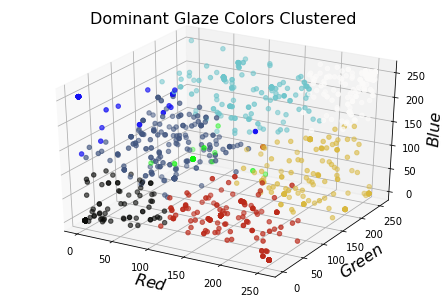

In [44]:
#https://buzzrobot.com/dominant-colors-in-an-image-using-k-means-clustering-3c7af4622036
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
r = []
g = []
b = []
for i in range(y_train.shape[0]):
    r.append(y_train[i][0])
    g.append(y_train[i][1])
    b.append(y_train[i][2])
    
centroid_r = []
centroid_g = []
centroid_b = []
for j in range(k):
    centroid_r.append(colors[j][0])
    centroid_g.append(colors[j][1])
    centroid_b.append(colors[j][2])

marker_size = [[2,2,2]]*k
ax.scatter(r, g, b, c = train_colors)
# plt.scatter(centroid_r, centroid_g, centroid_b, marker = "*", c = list(label_2_color_hex.values()))
plt.title('Dominant Glaze Colors Clustered', {'fontsize': 16})
ax.set_xlabel('$Red$', fontsize=16)
ax.set_ylabel('$Green$', fontsize=16)
ax.set_zlabel('$Blue$', fontsize=16)
plt.savefig('./img/glaze_clusters.jpg')
plt.show()


## Research Question:

1. Can we predict transparecny based on chemical composition of glaze?
    - Which chemicals are the most important in determining transparency?
2. Can we predict RGB colors based on chemical composition?
3. Firing temperature?
4. Does firing temp affect transparency?

## Visualization Ideas:

Shiny App with interactive chemical compositions and predicted color on scale

[this](https://www.rapidtables.com/convert/color/rgb-to-hex.html) returns color hex - Use in plot?

## ML Classifiers:
KNN, Random Forest, SVM